In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:


# Load the CSV data
csv_path = '/home/guoguo/projects/QML/data/gradient_under_precision.csv'
data = pd.read_csv(csv_path)

# Prepare the input and output data
X = data[['B_freq', 'B_ampl', 'x_offset', 'y_offset', 'z_offset']].values
y = data[['g1_x', 'g1_y', 'g1_z', 'g2_x', 'g2_y', 'g2_z']].values

# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
#  save the normalized data X， Y into a same csv file for later use

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Clip extreme values to remove outliers
y_train_tensor = torch.clamp(y_train_tensor, min=-1e7, max=1e7)
y_test_tensor = torch.clamp(y_test_tensor, min=-1e7, max=1e7)

# Apply log transformation to reduce skewness
y_train_tensor = torch.log1p(y_train_tensor)
y_test_tensor = torch.log1p(y_test_tensor)


In [3]:
# Define the neural network model
class GradientPredictor(nn.Module):
    def __init__(self, input_size, output_size):
        super(GradientPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = GradientPredictor(input_size, output_size)

# Custom loss function to maximize g1_x, g2_y and minimize g1_y, g1_z, g2_x, g2_z
# Custom loss function to maximize g1_x, g2_y and minimize g1_y, g1_z, g2_x, g2_z
def custom_loss(output):
    if output.dim() == 1:
        cost_g1_x = 1 - torch.sigmoid(output[0])  # Maximize g1_x
        cost_g2_y = 1 - torch.sigmoid(output[4])  # Maximize g2_y
        cost_g1_y = torch.sigmoid(output[1])      # Minimize g1_y
        cost_g1_z = torch.sigmoid(output[2])      # Minimize g1_z
        cost_g2_x = torch.sigmoid(output[3])      # Minimize g2_x
        cost_g2_z = torch.sigmoid(output[5])      # Minimize g2_z
    else:
        cost_g1_x = 1 - torch.sigmoid(output[:, 0])  # Maximize g1_x
        cost_g2_y = 1 - torch.sigmoid(output[:, 4])  # Maximize g2_y
        cost_g1_y = torch.sigmoid(output[:, 1])      # Minimize g1_y
        cost_g1_z = torch.sigmoid(output[:, 2])      # Minimize g1_z
        cost_g2_x = torch.sigmoid(output[:, 3])      # Minimize g2_x
        cost_g2_z = torch.sigmoid(output[:, 5])      # Minimize g2_z

    # Sum all costs to get the final loss value
    weight_max =0.6  # Weight for maximizing terms
    weight_min = 1-weight_max  # Weight for minimizing terms
    loss = (
        weight_max * (cost_g1_x.mean() + cost_g2_y.mean()) +
        weight_min * (cost_g1_y.mean() + cost_g1_z.mean() + cost_g2_x.mean() + cost_g2_z.mean())
)
    return loss
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)



In [4]:
# Training the model
epochs = 1000
training_losses = []
evaluation_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad() # Clear the gradients
    
    # Forward pass
    predictions = model(X_train_tensor)
    loss = custom_loss(predictions)
    training_losses.append(loss.item())
    
    # Backward pass
    loss.backward()
    optimizer.step()

    # Evaluate the model every 100 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor)
            test_loss = custom_loss(y_pred)
            evaluation_losses.append(test_loss.item())
        print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch [10/1000], Training Loss: 1.4016, Test Loss: 1.3997
Epoch [20/1000], Training Loss: 1.3823, Test Loss: 1.3801
Epoch [30/1000], Training Loss: 1.3583, Test Loss: 1.3555
Epoch [40/1000], Training Loss: 1.3275, Test Loss: 1.3239
Epoch [50/1000], Training Loss: 1.2877, Test Loss: 1.2832
Epoch [60/1000], Training Loss: 1.2360, Test Loss: 1.2301
Epoch [70/1000], Training Loss: 1.1693, Test Loss: 1.1618
Epoch [80/1000], Training Loss: 1.0852, Test Loss: 1.0757
Epoch [90/1000], Training Loss: 0.9820, Test Loss: 0.9705
Epoch [100/1000], Training Loss: 0.8617, Test Loss: 0.8487
Epoch [110/1000], Training Loss: 0.7299, Test Loss: 0.7161
Epoch [120/1000], Training Loss: 0.5954, Test Loss: 0.5820
Epoch [130/1000], Training Loss: 0.4689, Test Loss: 0.4570
Epoch [140/1000], Training Loss: 0.3595, Test Loss: 0.3498
Epoch [150/1000], Training Loss: 0.2720, Test Loss: 0.2646
Epoch [160/1000], Training Loss: 0.2060, Test Loss: 0.2007
Epoch [170/1000], Training Loss: 0.1579, Test Loss: 0.1542
Epoch 

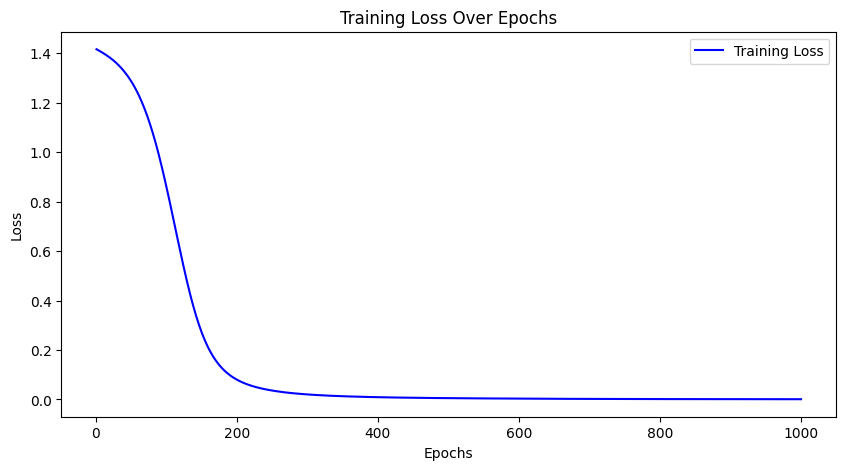

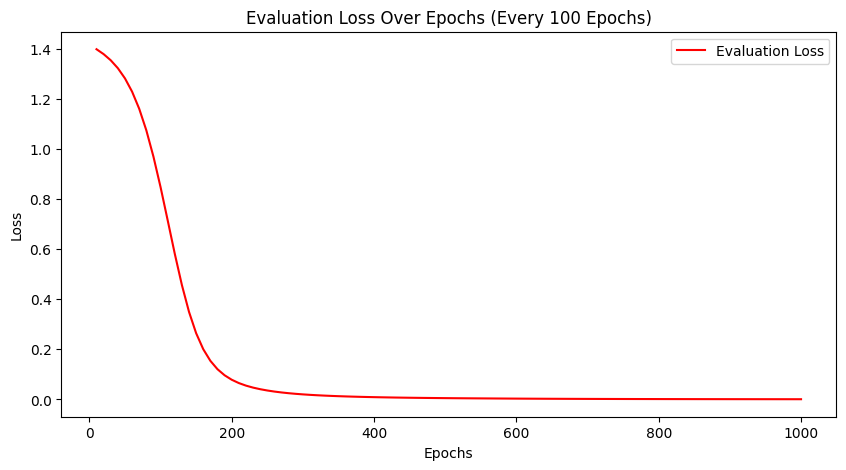

In [5]:
# Plot training and evaluation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), training_losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(10, epochs + 1, 10), evaluation_losses, label='Evaluation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evaluation Loss Over Epochs (Every 100 Epochs)')
plt.legend()
plt.show()


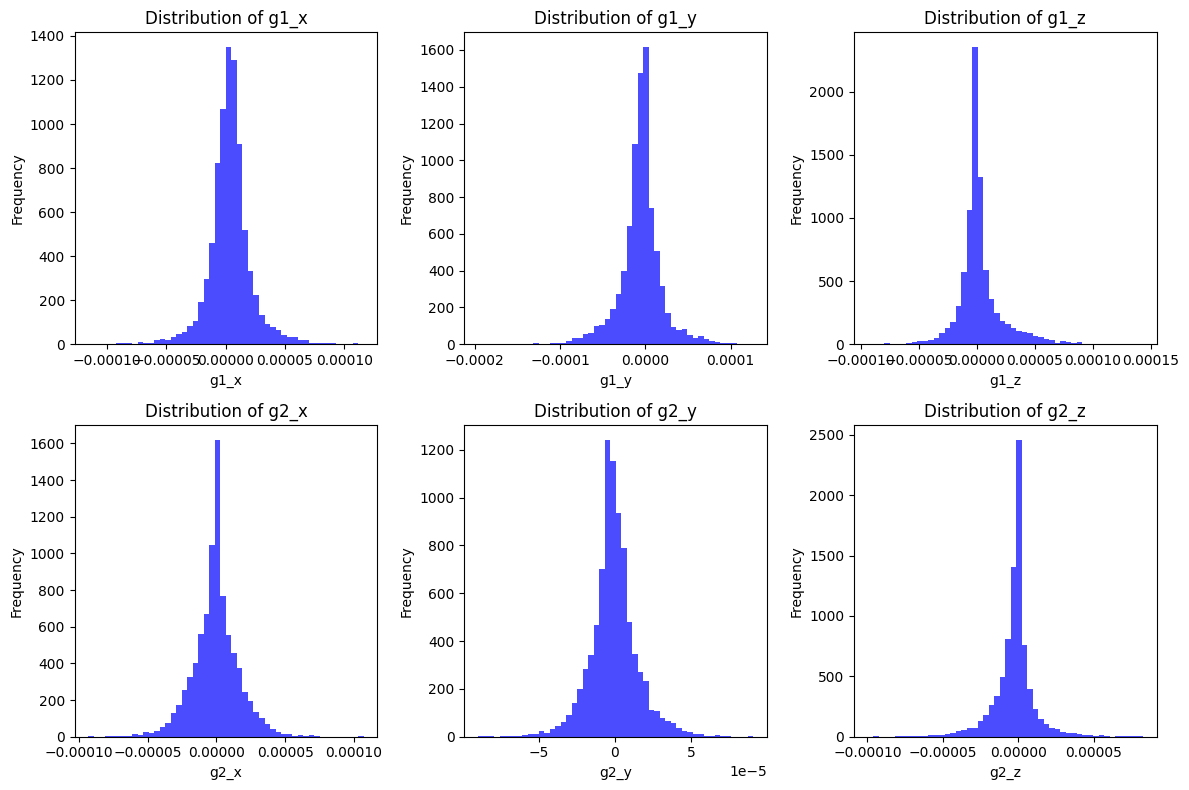

In [6]:
plt.figure(figsize=(12, 8))

for i, label in enumerate(['g1_x', 'g1_y', 'g1_z', 'g2_x', 'g2_y', 'g2_z']):
    plt.subplot(2, 3, i + 1)
    plt.hist(data[label], bins=50, color='blue', alpha=0.7)
    plt.xlabel(label)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {label}')

plt.tight_layout()
plt.show()

In [7]:
# Find optimal input values for fixed gradients
fixed_gradients = torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1], dtype=torch.float32)  # Example fixed gradients
initial_input = X_train_tensor[0].clone().detach().requires_grad_(True)  # Use a single initial point
optimizer_opt = optim.Adam([initial_input], lr=0.01)

# Keep track of optimization history
optimization_history = []

for step in range(500):
    optimizer_opt.zero_grad()
    predicted_gradients = model(initial_input)
    loss_opt = custom_loss(predicted_gradients)
    loss_opt.backward()
    optimizer_opt.step()

    # Store the current optimal input and loss value
    current_input = scaler_X.inverse_transform(initial_input.detach().numpy().reshape(1, -1))
    optimization_history.append([step + 1, loss_opt.item()] + current_input.flatten().tolist())

    if (step + 1) % 100 == 0:
        print(f'Step [{step + 1}/500], Optimization Loss: {loss_opt.item():.4f}')

# Save optimization history to CSV
optimization_history_df = pd.DataFrame(optimization_history, columns=["Step", "Loss", "B_freq", "B_ampl", "x_offset", "y_offset", "z_offset"])
optimization_history_df.to_csv('/home/guoguo/projects/QML/data/optimization_history.csv', index=False)

# Denormalize optimized input values
optimal_input = scaler_X.inverse_transform(initial_input.detach().numpy().reshape(1, -1))
print("Final Optimal Input Values for Fixed Gradients:")
print(optimal_input)
# output the first line of the data
print("The first line of the data:")
# denormalize the first line of the data
first_line = scaler_X.inverse_transform(X_train_tensor[0].detach().numpy().reshape(1, -1))
print(first_line)
# diff between the first line and the optimal input

diff = optimal_input - first_line
print("The difference between the first line and the optimal input:")
print(diff)



Step [100/500], Optimization Loss: 0.0000
Step [200/500], Optimization Loss: 0.0000
Step [300/500], Optimization Loss: 0.0000
Step [400/500], Optimization Loss: 0.0000
Step [500/500], Optimization Loss: 0.0000
Final Optimal Input Values for Fixed Gradients:
[[ 3.03441040e+03  1.22803256e-01 -1.28764331e+00  2.88677961e-01
   4.53079157e-02]]
The first line of the data:
[[ 3.0330000e+03  8.0674005e-01 -1.1000000e+00  5.0000000e-01
   5.6000002e-02]]
The difference between the first line and the optimal input:
[[ 1.4104004  -0.6839368  -0.18764329 -0.21132204 -0.01069209]]


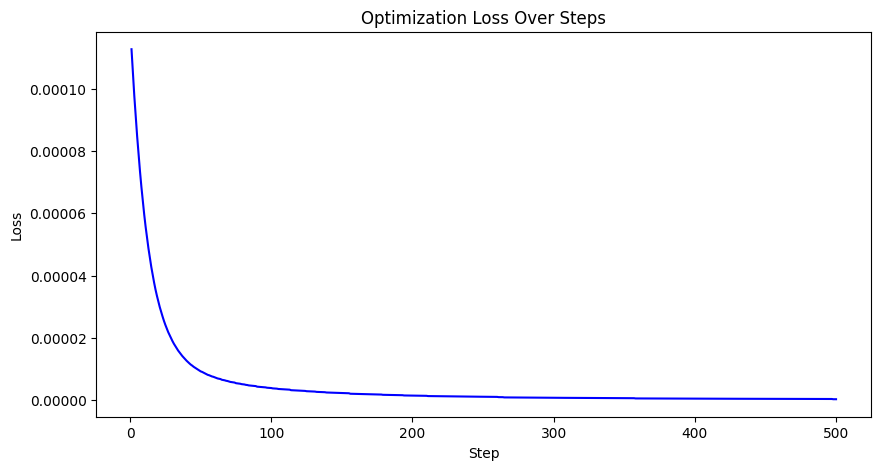

In [8]:
# plot the optimization history
plt.figure(figsize=(10, 5))
plt.plot(optimization_history_df['Step'], optimization_history_df['Loss'], color='blue')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Optimization Loss Over Steps')
plt.show()


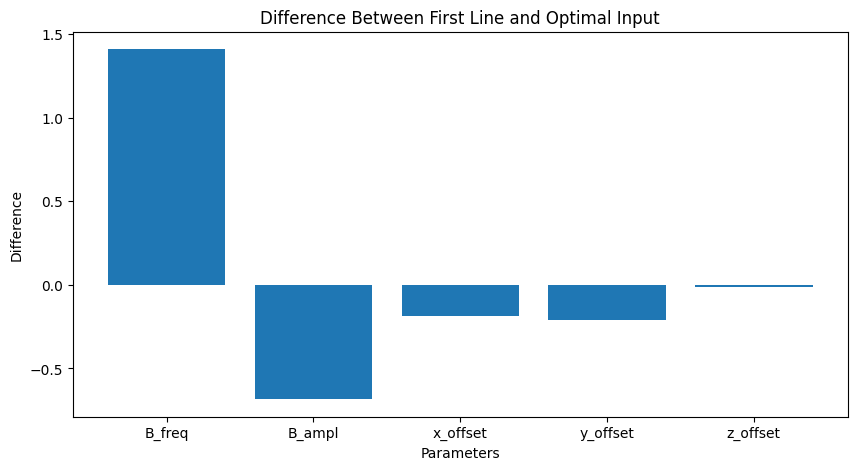

In [9]:
# plot the difference between the first line and the optimal input
plt.figure(figsize=(10, 5))
plt.bar(optimization_history_df.columns[2:], diff.flatten())
plt.xlabel('Parameters')
plt.ylabel('Difference')
plt.title('Difference Between First Line and Optimal Input')
plt.show()
